# Setup

### Imports / Constants / Functions

In [1]:
# Disable Tensorflow's warnings
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pickle

2022-10-20 14:50:16.925906: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Functions used below for image display 

def display_imgs(x, n):
    plt.figure(figsize=(20, 5))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(np.array(x[i]).astype('uint8'), vmax=1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

def display_encoded_imgs(x, n):
    plt.figure(figsize=(20, 5))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(np.array(x[i]), vmax=1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

def display_single_image(img, title):
    plt.figure(figsize=(20, 5))
    plt.imshow(img)
    plt.axis("off")
    plt.title(title)

In [4]:
IMG_HEIGHT = 228
IMG_WIDTH  = 228
BATCH_SIZE = 64

### Load Data

In [5]:
# Load data from directory 
dataset = tf.keras.utils.image_dataset_from_directory('data/0_data_unseen/',
                                            image_size=(IMG_HEIGHT, IMG_WIDTH),
                                            batch_size=BATCH_SIZE)

# Convert BatchDataset to np array 
dataset = np.concatenate(list(dataset.map(lambda x, y: x))) 

Found 5 files belonging to 1 classes.


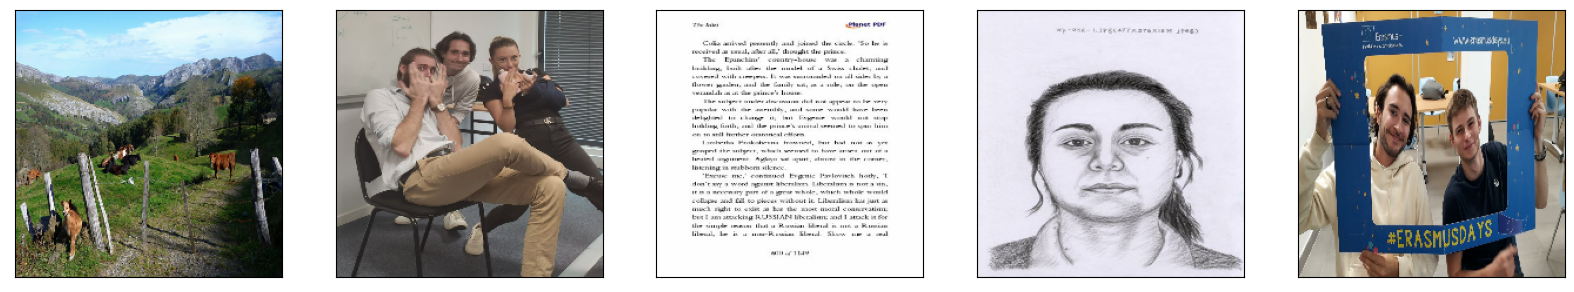

In [6]:
display_imgs(dataset, 5)

# Binary Classifier (Deliverable 1)

In [7]:
# Import Classifier Model
bin_classifier_path = 'models/bin_10.19.2022_15:29:58_0.93%'
bin_classifier = tf.keras.models.load_model(bin_classifier_path)

In [8]:
# Use model to classify data
predictions = bin_classifier.predict(dataset)

# Save classified photos in a table
photos = []
for prediction, image in zip(predictions, dataset):
    # Prediction equal to 1 means photo
    if int(np.round(prediction)) == 1:
            photos.append(image)

1/1 [==============================] - 1s 1s/step


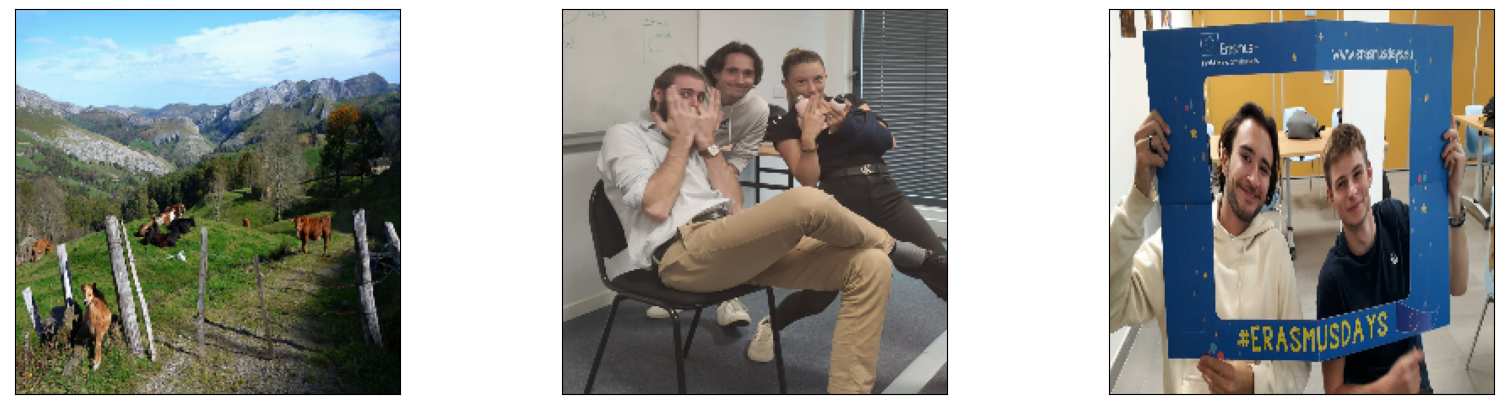

In [9]:
display_imgs(photos, len(photos))

# Denoising (Deliverable 2)

In [10]:
# Convert array photo to Dataset
photos = np.array(photos).astype('float32') / 255.
photos_dataset = tf.data.Dataset.from_tensor_slices(photos).batch(1)

In [11]:
# Define SSIM function for Denoiser model accuracy   
def ssim_accuracy(y_true, y_pred):
    return tf.image.ssim(y_true, y_pred, 1.0)

# Import Denoiser Model
denoiser_path = 'models/denoiser_10.20.2022_14:46:42'
denoiser = tf.keras.models.load_model(denoiser_path, custom_objects={"ssim_accuracy":ssim_accuracy})

In [12]:
# Use model to denoise photos
encoded_photos_dataset = denoiser.predict(photos_dataset)

3/3 [==============================] - 0s 3ms/step


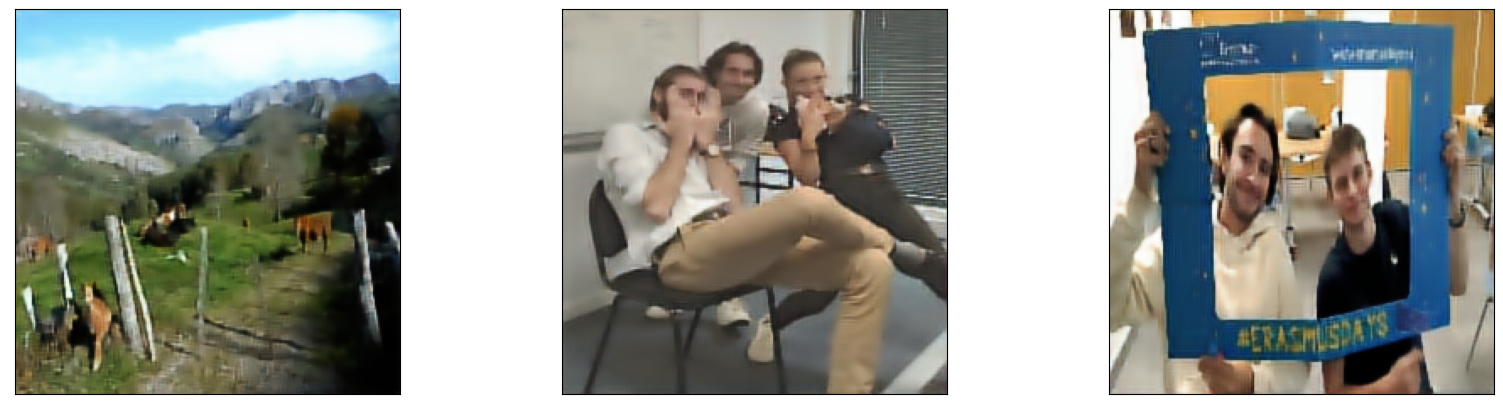

In [13]:
display_encoded_imgs(encoded_photos_dataset, len(encoded_photos_dataset))

# Captioning (Deliverable 3)

In [14]:
# Load Inception model for feature extration
image_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output

image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

In [15]:
# Import Encoder (CNN model)
cap_encoder_path = 'models/cap_encoder_10.20.2022_12:22:21'
encoder = tf.keras.models.load_model(cap_encoder_path)

# Import Decoder (RNN model)
cap_decoder_path = 'models/cap_decoder_10.20.2022_12:22:21'
decoder = tf.keras.models.load_model(cap_decoder_path)

In [16]:
# Load Vocabulary for captioning
with open('data/3_train_captions', 'rb') as file:
    train_captions = pickle.load(file)

caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.lower(inputs)
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+.,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 50
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

# Create the tokenized vectors
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [18]:
max_length = 7
attention_features_shape = 64

def evaluate(image):
    attention_plot = np.zeros((max_length, attention_features_shape))

    hidden = decoder.reset_state(batch_size=1)

    temp_input = tf.expand_dims(tf.convert_to_tensor(image), 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0],
                                                 -1,
                                                 img_tensor_val.shape[3]))

    features = encoder(img_tensor_val)

    dec_input = tf.expand_dims([tf.cast(word_to_index('<start>'),tf.int64)], 0)
    result = []
    for i in range(max_length):
        predictions, hidden, attention_weights = decoder.call(dec_input,
                                                         features,
                                                         hidden)

        attention_plot[i] = tf.reshape(attention_weights, (-1, )).numpy()

        predicted_id = tf.random.categorical(predictions, 1)[0][0].numpy()
        predicted_word = tf.compat.as_text(index_to_word(predicted_id).numpy())
        result.append(predicted_word)

        if predicted_word == '<end>':
            return result, attention_plot

        dec_input = tf.cast(tf.expand_dims([predicted_id], 0),tf.int64)

    attention_plot = attention_plot[:len(result), :]
    return result, attention_plot

In [19]:
def predict(dataset):
    for image in dataset:
        img = tf.convert_to_tensor(image)
        img = tf.keras.layers.Resizing(299, 299)(img)
        img = tf.keras.applications.inception_v3.preprocess_input(img)

        result, attention_plot = evaluate(img)
        display_single_image(image, ' '.join(result))


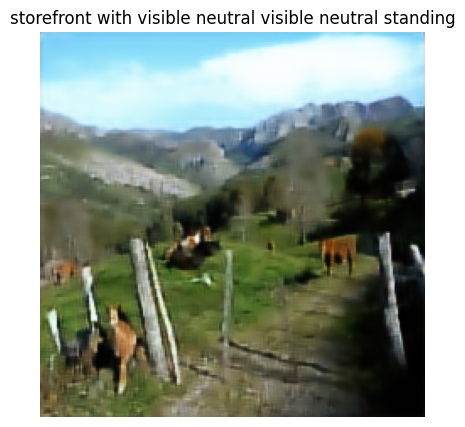

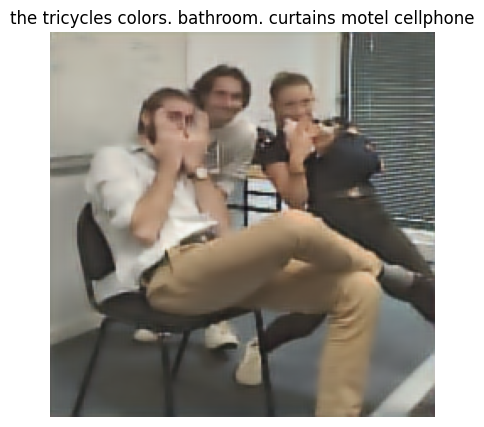

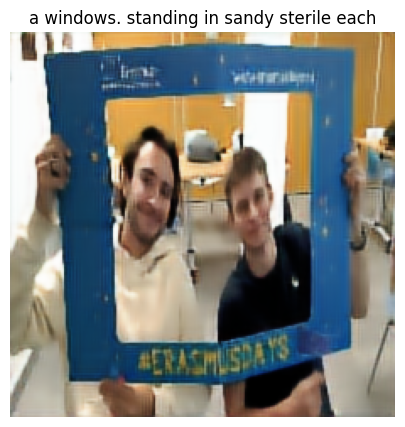

In [20]:
predict(encoded_photos_dataset)